In [7]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.cross_validation import train_test_split
sns.set()
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

# Final project: Demand Forecasting

### Alexander Pletnev and Polina Pilyugina

## Outline of the problem

Describe the problem you want to solve using data science techniques. Why is it important? How your ML model can help (e.g., reduce costs, increase quality, etc.)? (6 points)

##### Problem:
* Poor tools and technics in **Microsoft Excel** (mainly linear regression, no complex ML models)
* Excel is not well-suited to deal with **large amounts** of time series
* As a result, they rely on **aggregate level** adjustments

##### Importance:
* In many cases, the aggregation is prone to **mistakes** and poorly reflects the underlying statistical process
* **Mistakes** in forecasted demand result in **over/underproduction**
* Such mistakes can cause **lost sales** or **"rotten"** products

## Solution

* Use more complex tools and **ML technics** to achieve more precise results
* Construct the repeatable procedure, to **forecast demand** for the **next month**
* The model with the best accuracy chosen

## Start by importing all the avalilable data

##### Load the data using pandas and split the data frame into X (inputs) and y (outputs). (2 points)

In [23]:
# Load the data using pandas

# month_q=pd.read_csv('total_q_mon.csv', sep=';')#, index_col='item')
# month_parent=pd.read_csv('total_parent_mon.csv', sep=';')

rpd_q=pd.read_csv('total_q_rpd.csv', sep=';')
rpd_parent=pd.read_csv('total_parent_rpd.csv', sep=';')

### For this part of analysis, data will be splitted further, after the encoding of target variable.

Initial data containts 43 months (columns from 108 to 151) and 833 time serieses of quantity of particular item ordered for the particular month. Also data contains information about nu,ber of parents, siblings and children.

In [24]:
rpd_q.head()

,item,num_parents,num_children,num_siblings,108,109,110,111,112,113,...,142,143,144,145,146,147,148,149,150,151
0,10106,1,0,11,0,400,2000,0,0,0,...,0,0,0,0,1200,2400,0,600,2600,0
1,10362,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10601,1,1,10,0,0,0,200,0,0,...,3600,0,0,0,0,200,200,2000,0,200
3,10646,3,0,8,0,0,0,0,0,0,...,200,800,0,400,0,0,0,0,0,200
4,10659,1,0,2,0,0,0,600,200,0,...,600,5600,1600,1400,1200,0,800,6600,400,2200


In [25]:
#function for plotting time serieses from initial data (drop not ts variables)

def plot_ts_rpd(df, i):
    plt.figure(figsize=(15,3))
    plt.plot(df.drop(['item', 'num_parents', 'num_children', 'num_siblings'], axis=1).T[i])

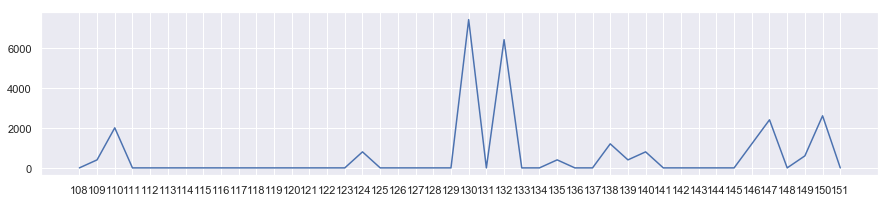

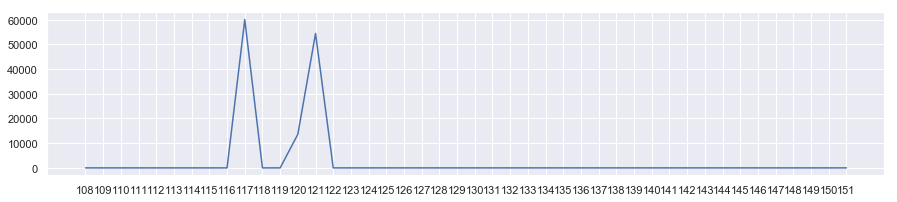

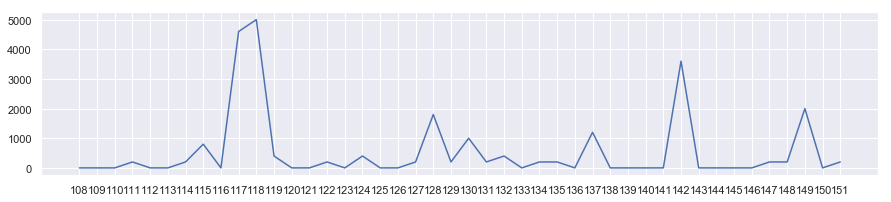

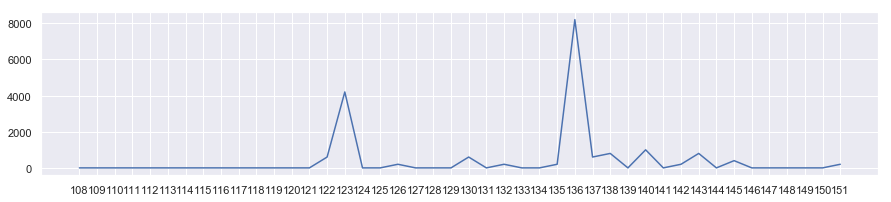

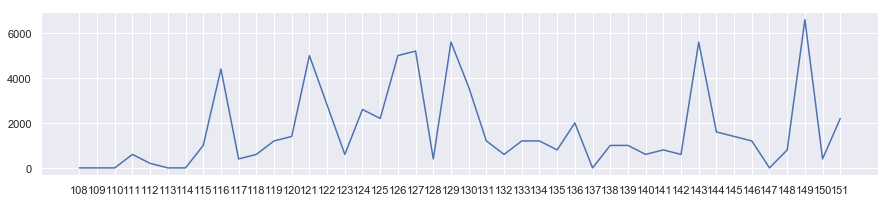

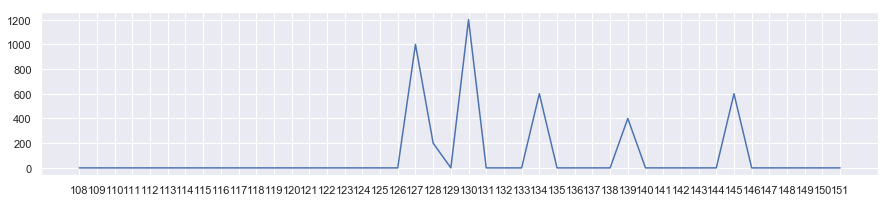

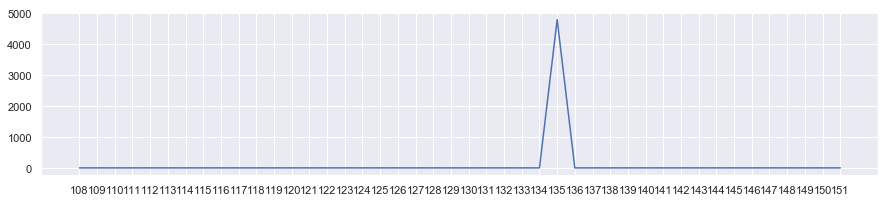

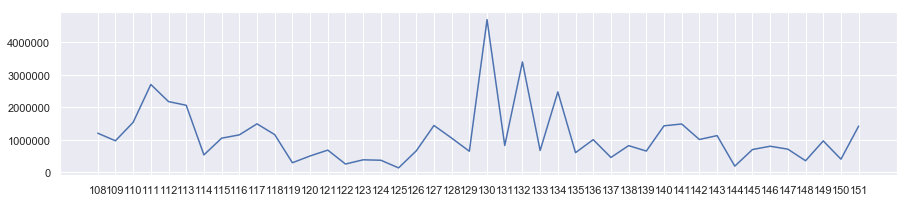

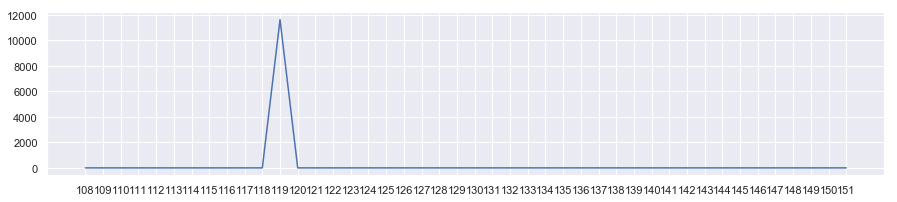

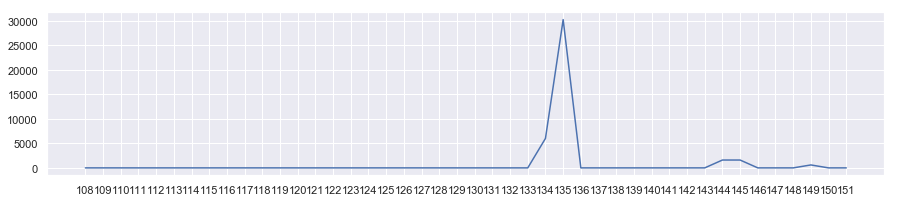

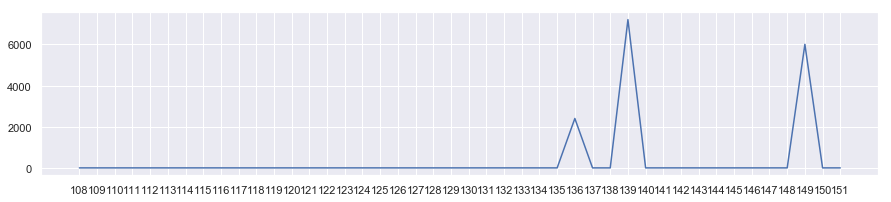

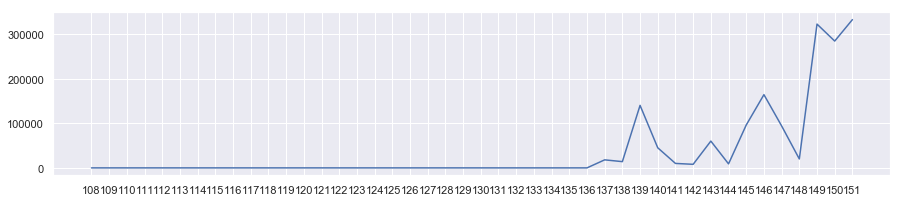

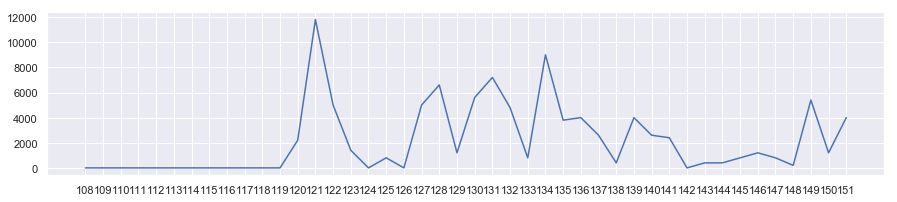

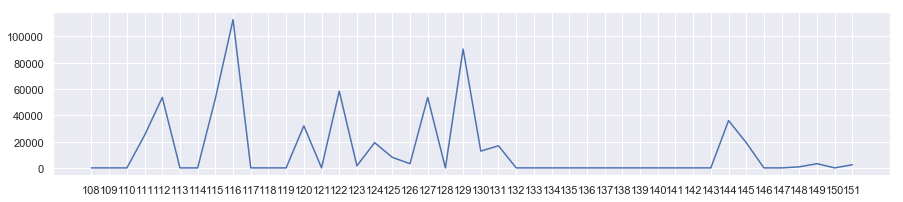

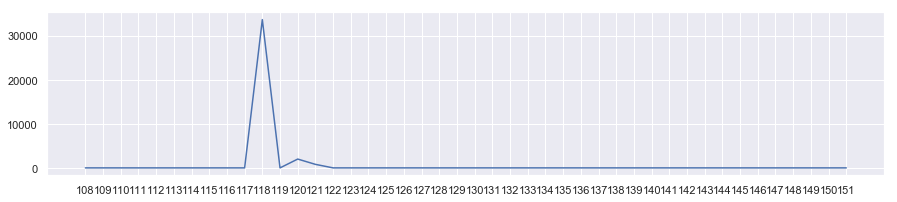

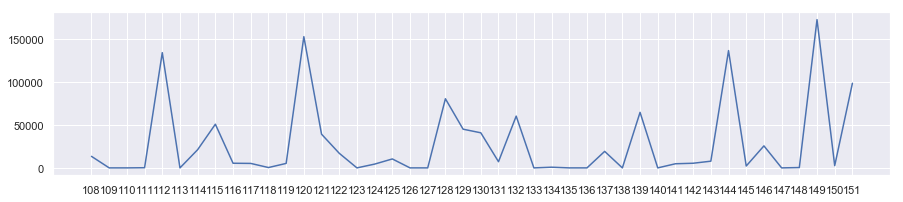

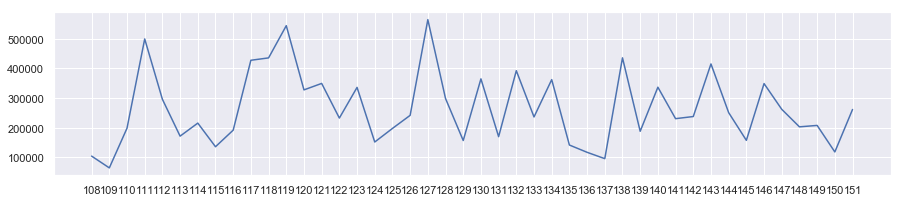

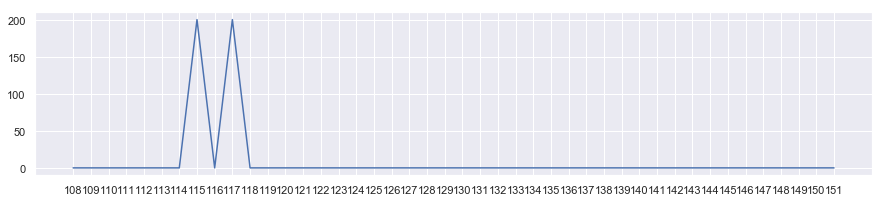

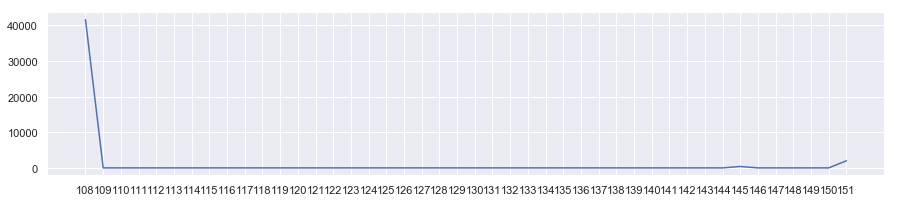

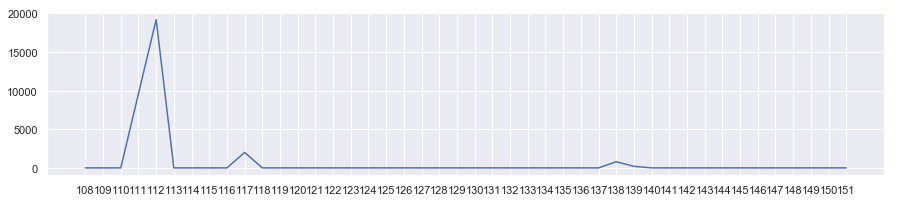

In [26]:
#potting some ts to search for some patterns

for i in range(20):#rpd_q.shape[0]):
    plot_ts_rpd(rpd_q, i)
    

Seems reasonable to create category, which will count non-zero values of ts

## Data preprocessing

￼Prepare your dataset:
* encode categorical variables (if any),
* handle missing variables (if any),
* generate new features (if you have some intuition that these features can be useful). 
<br>Preprocess target variable if needed (e.g., combine various classification problems into a single one or convert the target variable to a binary one.) 
<br>For each transformation give a clear explanation of your motivation. (7 points)


In [27]:
non_zeroes=pd.DataFrame(rpd_q.drop(['item', 'num_parents', 'num_children', 'num_siblings'], axis=1).T.astype(bool).sum(axis=0),
                columns=['non_zeroes'])

rpd_q=rpd_q.join(non_zeroes)

In [28]:
#function for stacking, designed to have balanced classes
def intervals(x):
    if x <=5:
        return "lowest"
    elif x > 5 and x<=22:
        return 'medium low'
    elif x > 22 and x<=33:
        return 'medium high'
    elif x > 33 and x<=44:
        return 'highest'

## Visual analysis

￼Perform an exploratory analysis of the data via visualization with Seaborn. Try to find meaningful patterns in the data which can be used to make machine learning task more specific or to help with selection and tuning ML models. Perform additional preprocessing of your data if your findings suggest this (again, all steps should be motivated). If there are several options of target variables, you can select some of them after this step with a couple of sentences explaining your choice. (6 points).


Text(0.5,1.01,'Distribution of zeroes counts')

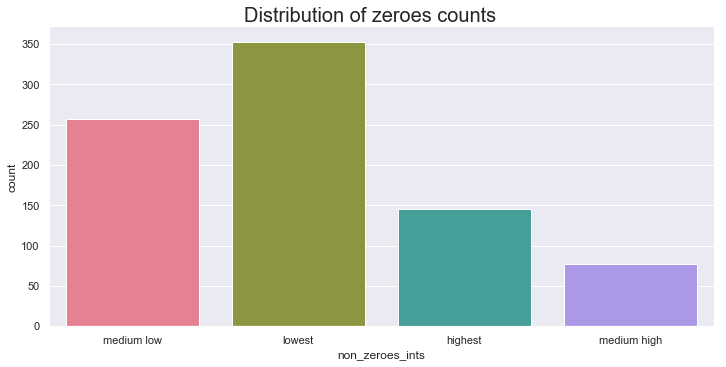

In [29]:
rpd_q['non_zeroes_ints']=rpd_q['non_zeroes'].apply(intervals)
m=sns.catplot(x="non_zeroes_ints", kind="count", palette="husl", data=rpd_q, aspect=2)
m.fig.suptitle('Distribution of zeroes counts', fontsize=20, y=1.01)

Text(0.5,1.01,'Distribution of number of parents')

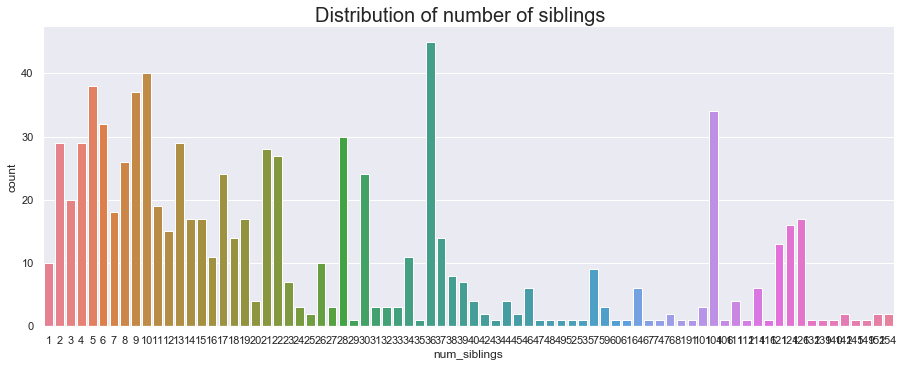

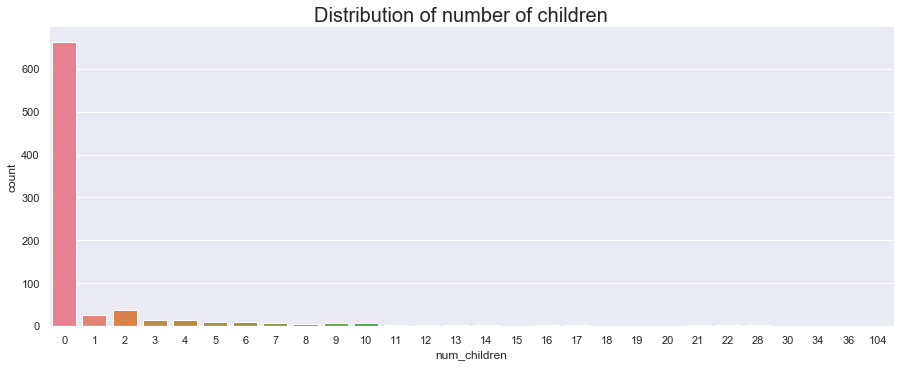

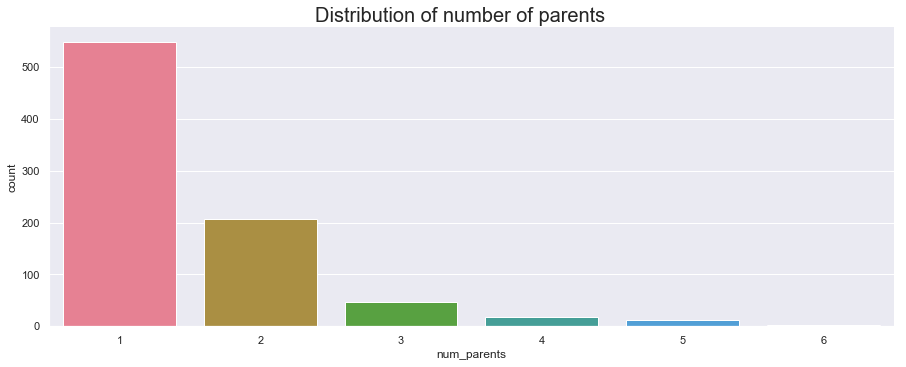

In [30]:
#Some further vizualization to see how figures are distributed.

a=sns.catplot(x="num_siblings", kind="count", palette="husl", data=rpd_q, aspect=2.5)
a.fig.suptitle('Distribution of number of siblings', fontsize=20, y=1.01)
b=sns.catplot(x="num_children", kind="count", palette="husl", data=rpd_q, aspect=2.5)
b.fig.suptitle('Distribution of number of children', fontsize=20, y=1.01)
c=sns.catplot(x="num_parents", kind="count", palette="husl", data=rpd_q, aspect=2.5)
c.fig.suptitle('Distribution of number of parents', fontsize=20, y=1.01)

Need to understand the target variable form, whether can classify somehow and maybe balance

In [31]:
#look on target stats

pd.DataFrame(rpd_q['151']).describe()

,151
count,8.330000e+02
mean,1.377191e+04
std,8.516600e+04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,8.000000e+02
max,1.419000e+06


In [32]:
#function for stacking, designed to have balanced classes
def intervals_target(x):
    if x <=1000:
        return 1
    elif x > 1000 and x<=50000:
        return 2
    elif x > 50000:
        return 3

In [33]:
rpd_q['151_cat']=rpd_q['151'].apply(intervals_target)

Text(0.5,1.01,'Distribution of target into categories')

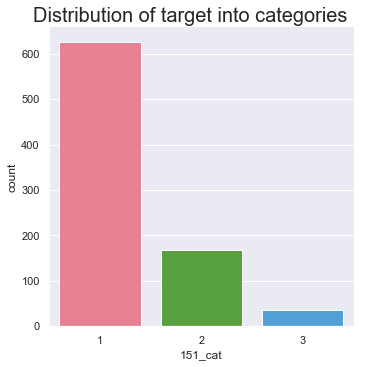

In [34]:
g=sns.catplot(x="151_cat", kind="count", 
            palette="husl", data=rpd_q, aspect=1)
g.fig.suptitle('Distribution of target into categories', fontsize=20, y=1.01)

Classes are still unbalanced, but we can account for that usind "weighted" for accuracy scores

## Now can split the data

In [35]:
from sklearn.model_selection import train_test_split

# split data into X y and train test and validation

X=rpd_q.drop(['151', '151_cat', 'non_zeroes_ints'], axis=1)
#y=rpd_q['151_cat']
y=rpd_q.loc[:,['151', '151_cat']]

# x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)
x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=None)

Text(0.5,1.01,'Data pairplot')

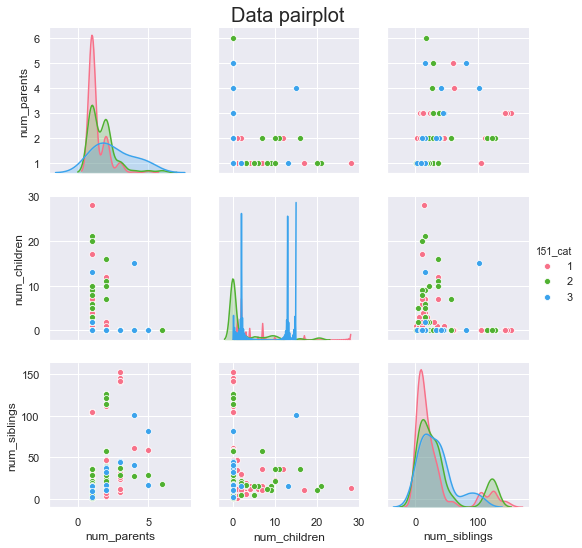

In [36]:
# try to make some representation of the data
d=sns.pairplot(data=rpd_q.loc[:300], 
             vars=['num_parents', 'num_children', 'num_siblings'], 
             hue='151_cat', 
             palette='husl')
d.fig.suptitle('Data pairplot', fontsize=20, y=1.01)

Can see that most items have no children at all, while there are still some items with large amount of children. Number of siblings has the largest range and varies for different items. But the possible number of parents is limited to 6 values. Distribution of items, depending on the number of particular relatives, is not uniform, so this veature might help in future forecasting.

## Model choice

In [37]:
for df in [x_tr, y_tr, x_te, y_te]:
    print(df.shape)
    df=pd.DataFrame(df)

(666, 48)
(666, 2)
(167, 48)
(167, 2)


In [38]:
def rmse(y_true, y_predicted):
    return np.sqrt(((y_true - y_predicted)**2).mean())

In [39]:
#Data frame for soring the results

results=pd.DataFrame(index=['rmse', 'accuracy'])

In [40]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score



### Linear regression

In [41]:
lr = LinearRegression(fit_intercept=True)
lr.fit(x_tr, y_tr['151'])
y_pred = lr.predict(x_te)

print(rmse(y_te['151'], y_pred))
results['linear regression']=0
results['linear regression']['rmse']=rmse(y_te['151'], y_pred)

27845.42751504863


In [42]:
comb=pd.DataFrame(data=y_te['151'])
y_pred=pd.Series(y_pred, name='predicted')
comb.reset_index(inplace=True)
comb=comb.join(y_pred)
# comb=comb.sort_values(by='151')
# comb.reset_index(inplace=True)

# plt.figure(figsize=(15,5))
# plt.plot(comb.index, comb['151'], 'ro', markersize=5);
# plt.plot(comb.index, comb.predicted, linewidth=4);

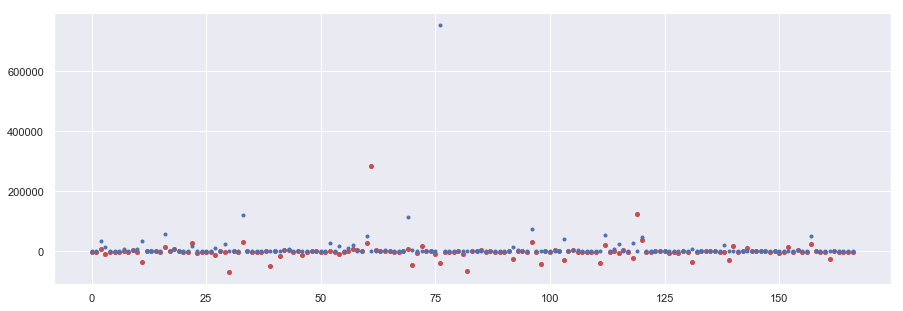

In [43]:
# plotting the residuals
plt.figure(figsize=(15,5))
plt.plot(comb['151']-comb.predicted, 'ro', markersize=4)
plt.plot(comb['151'], 'bo', markersize=3)

### Ridge

In [44]:
clf = Ridge()
clf.fit(x_tr, y_tr['151']) 
# scores = cross_val_score(clf, X, y['151'], scoring='f1_weighted')

y_pred=clf.predict(x_te)
results['ridge']=0
results['ridge']['rmse']=rmse(y_te['151'], y_pred)

### Logistic regression

In [45]:
kfold = KFold(n_splits=5, shuffle=True)
cv = kfold.split(x_tr, y_tr['151_cat'])

clf = LogisticRegression(penalty='l1')
clf.fit(x_tr, y_tr['151_cat'])
y_pred = clf.predict(x_te)

scores = cross_val_score(clf, X, y['151_cat'], scoring='f1_weighted', cv=cv)


results['logistic regression']=0
results['logistic regression']['accuracy']='{0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std())

In [46]:
print(confusion_matrix(y_te['151_cat'], y_pred))

[[113   9   2]
 [ 13  20   4]
 [  0   2   4]]


### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

clf = RandomForestClassifier(n_estimators=100) 
clf.fit(x_tr, y_tr['151_cat']) 

y_pred=clf.predict(x_te)
scores = cross_val_score(clf, X, y['151_cat'], scoring='f1_weighted')

results['random forest']=0
results['random forest']['accuracy']='{0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std())

### Gradient Boosting

In [48]:
clf = GradientBoostingClassifier(n_estimators=20)
clf.fit(x_tr, y_tr['151_cat']) 


y_pred=clf.predict(x_te)
scores = cross_val_score(clf, X, y['151_cat'], scoring='f1_weighted')

results['gradient boosting']=0
results['gradient boosting']['accuracy']='{0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std())

### Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_tr, y_tr['151_cat'])

y_pred=clf.predict(x_te)
scores = cross_val_score(clf, X, y['151_cat'], scoring='f1_weighted')

results['decision tree']=0
results['decision tree']['accuracy']='{0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std())

### Xgboost

In [50]:
from xgboost import XGBClassifier


clf = XGBClassifier()
clf.fit(x_tr, y_tr['151_cat'])

y_pred=clf.predict(x_te)
scores = cross_val_score(clf, X, y['151_cat'], scoring='f1_weighted')

results['xgboost']=0
results['xgboost']['accuracy']='{0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std())

## Cross-validation

￼Analyze the obtained results (interesting findings, remarks on ML experiments, the applicability of the model in a real-life scenario) and make an overall conclusion. Does your model solve the problem stated at the beginning? Can you estimate the impact of your ML model on the problem domain (10 points)?


In [51]:
results

,linear regression,ridge,logistic regression,random forest,gradient boosting,decision tree,xgboost
rmse,27845,27845,0,0,0,0,0
accuracy,0,0,0.848 ± 0.017,0.883 ± 0.009,0.875 ± 0.012,0.853 ± 0.023,0.879 ± 0.015


As for the regression analysis, it shows enormous MSE for uncategorized target variable. This seems to be caused by the features of the data: there are lots of zeros and several harsh outliers.<br>
The prediction of categorized variable, on the other hand, was successful and the best accuracy (calculated taking into account the unbalanceness between classes) is for the **random forest**, **gradient boosting** and **xgboosting**.
<br>We suggest to use one of this three models in future to predict approximate loadness of the demand.

### Clustering

In [7]:
df_rpd_split_f = pd.read_csv("topo_out_rpd_split.csv")
df_rpd_split_f.head()
X = df_rpd_split_f.loc[:,'item':'151_parent_quantity']
X = X.drop(columns = 'parent_item')
X = X.drop(columns = 'future_flag')
X.head()

,item,108_item,109_item,110_item,111_item,112_item,113_item,114_item,115_item,116_item,...,142_parent_quantity,143_parent_quantity,144_parent_quantity,145_parent_quantity,146_parent_quantity,147_parent_quantity,148_parent_quantity,149_parent_quantity,150_parent_quantity,151_parent_quantity
0,10106,0,400,2000,0,0,0,0,0,0,...,0,0,0,0,800,1200,0,400,600,0
1,10106,0,400,2000,0,0,0,0,0,0,...,0,0,0,0,800,1000,0,200,400,0
2,10106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,400,0,0,400,0
3,10106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,200,0
4,10362,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage
np.set_printoptions(precision=5, suppress=True)
# generate the linkage matrix
Z = linkage(X, 'ward')

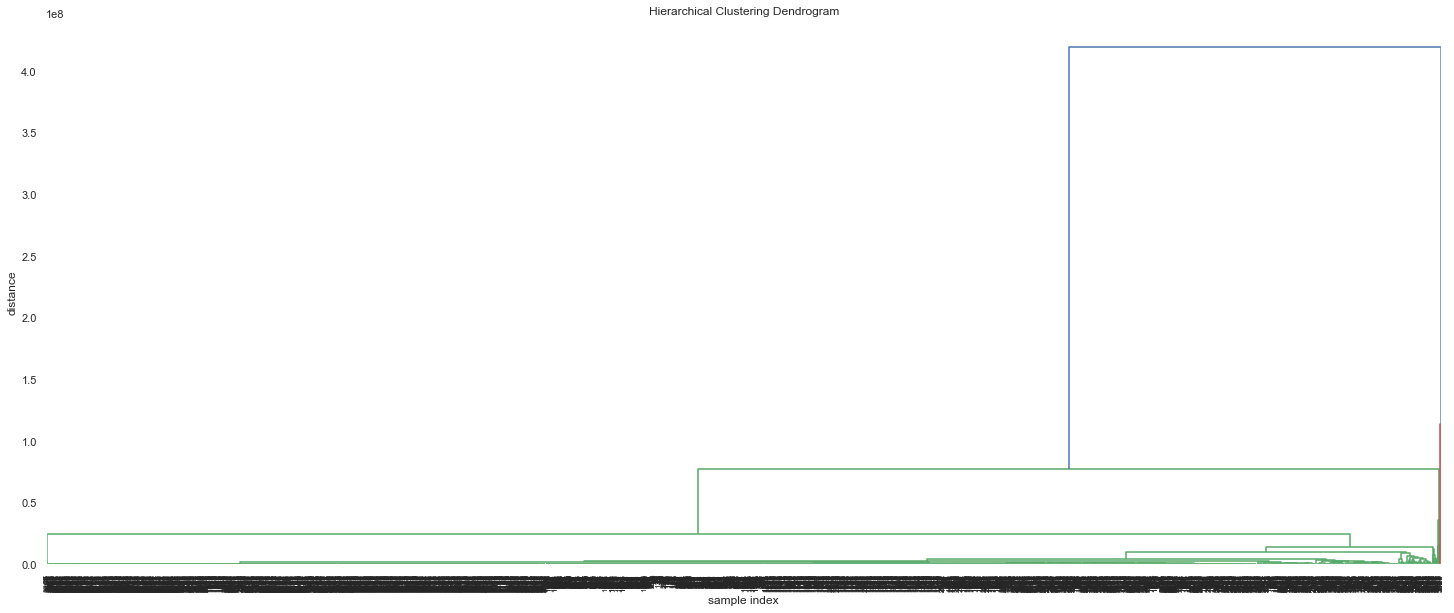

In [9]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c
# Let's make Dendogram to better see
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8., 
)
plt.show()

Let's make the Dendogram more visually appealing

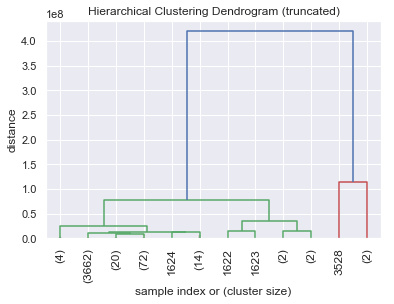

In [10]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

We will use try Time Series Forecasting using **ARIMA**. Firstly we will do it without (parents info and f, because of need Arima input). It seems that this is the best method for the task, especially because or data is seasonal. 

In [7]:
df = pd.read_csv("input_1.csv")
df.head()
X = df.drop(columns = 'parent_item')
X = X.drop(columns = 'parent_quantity_ecd')
X = X.groupby(['rpd','item']).sum()
X = X.drop(columns = 'future_flag')
dict_of_items = {k: v for k, v in X.groupby('item')}
X.head()
#for idx in dict_of_items:
    #print(idx)

quantity_ecd
rpd item               
108 10949       2404000
    12013         26200
    12486        160400
    12589         41600
    13394         24600

Let's pick only items with sufficient time series for accuracy.  

In [8]:
%%capture
results = {}
import statsmodels

#mean_squared_error(dict_of_items[99964],results[99964].predict())
for idx in dict_of_items:
    tempX = dict_of_items[idx]
    if (tempX.shape[0]<36):
        continue
    mod = statsmodels.tsa.statespace.sarimax.SARIMAX(tempX,
                                    order=(0, 0, 0),
                                    seasonal_order=(0, 0, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results[idx] =mod.fit()

#print(results[idx].summary().tables[1])

In [9]:
results_predicted ={}
for idx in results:
    results_predicted[idx] = results[idx].predict()

In [10]:
from sklearn.metrics import mean_squared_error 
mse_df = pd.DataFrame(columns = ['item','mse'])
for idx in results:
    mse_df.loc[idx] = [idx,mean_squared_error(dict_of_items[idx],results_predicted[idx])]
mse_df = mse_df.sort_values(by='mse')
mse_df.head()

,item,mse
29955,29955.0,1.899500e+07
65498,65498.0,3.321727e+07
82305,82305.0,3.712000e+07
15784,15784.0,3.712000e+07
10659,10659.0,3.712000e+07


We have pretty high RMSE values. But still let's explore

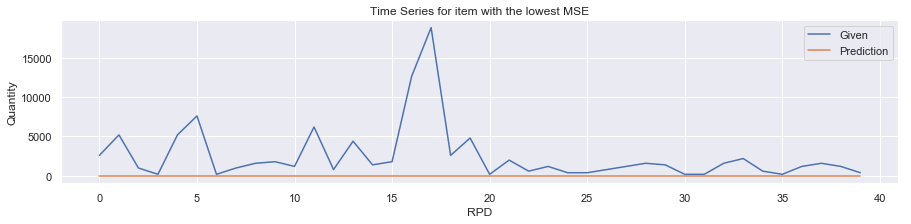

In [11]:
plt.figure(figsize=(15,3))
plt.plot(list(dict_of_items[mse_df.loc[:,'item'].iloc[0]].values),label = "Given")
plt.plot(list(results_predicted[mse_df.loc[:,'item'].iloc[0]]),label = "Prediction")
plt.xlabel('RPD')
plt.ylabel('Quantity')
plt.title('Time Series for item with the lowest MSE')
plt.legend();


Let's now make parameter selection for this item in order to hopefully decrease MSE

In [12]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import statsmodels.api as sm
p = d = q = range(0, 2)
#  mse_df.loc[:,'item'].iloc[0] 
# dict_of_items[mse_df.loc[:,'item'].iloc[0] ]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dict_of_items[mse_df.loc[:,'item'].iloc[0]],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:766.9490899023765
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:944.6249142247052
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:539.7299901887034
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:548.7138378773437
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:533.4821161640668
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:302.4984636802068
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:737.929843567753
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2400.562094495706
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:516.164088588056
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:544.1895850236242
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:506.1797111938072
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:304.1791152113557
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:742.1777901765024
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:940.9248080452232
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AI

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 263.
Therefore let's consider this to be optimal option out of all the models 

Let's make  a new prediction with this parameters

In [13]:
%%capture
results_2 = {}
for idx in dict_of_items:
    tempX_2 = dict_of_items[idx]
    if (tempX_2.shape[0]<36):
        continue
    mod = statsmodels.tsa.statespace.sarimax.SARIMAX(tempX_2,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results_2[idx] =mod.fit()
    #print(results[idx].summary().tables[1])

In [14]:
results_predicted_2 ={}
for idx in results_2:
    results_predicted_2[idx] = results_2[idx].predict()
mse_df_2 = pd.DataFrame(columns = ['item','mse'])
for idx in results_2:
    mse_df_2.loc[idx] = [idx,mean_squared_error(dict_of_items[idx],results_predicted_2[idx])]
mse_df_2 = mse_df_2.sort_values(by='mse')
mse_df_2.head()    

,item,mse
29955,29955.0,1.725305e+07
38502,38502.0,2.875148e+07
65498,65498.0,3.148465e+07
82305,82305.0,3.392849e+07
15784,15784.0,3.392849e+07


MSE has reduced a bit!

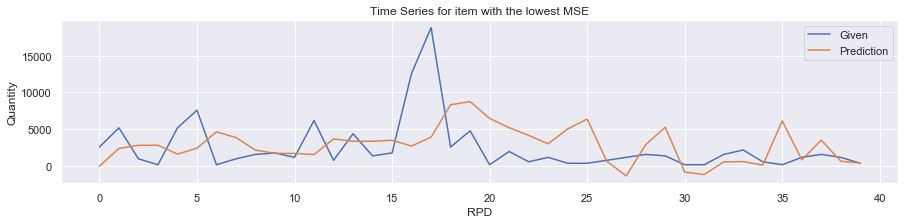

In [15]:
plt.figure(figsize=(15,3))
plt.plot(list(dict_of_items[mse_df_2.loc[:,'item'].iloc[0]].values),label = "Given")
plt.plot(list(results_predicted_2[mse_df_2.loc[:,'item'].iloc[0]]),label = "Prediction")
plt.xlabel('RPD')
plt.ylabel('Quantity')
plt.title('Time Series for item with the lowest MSE')
plt.legend();

Even though it has high MSE, the plots are pretty simular, which is nice

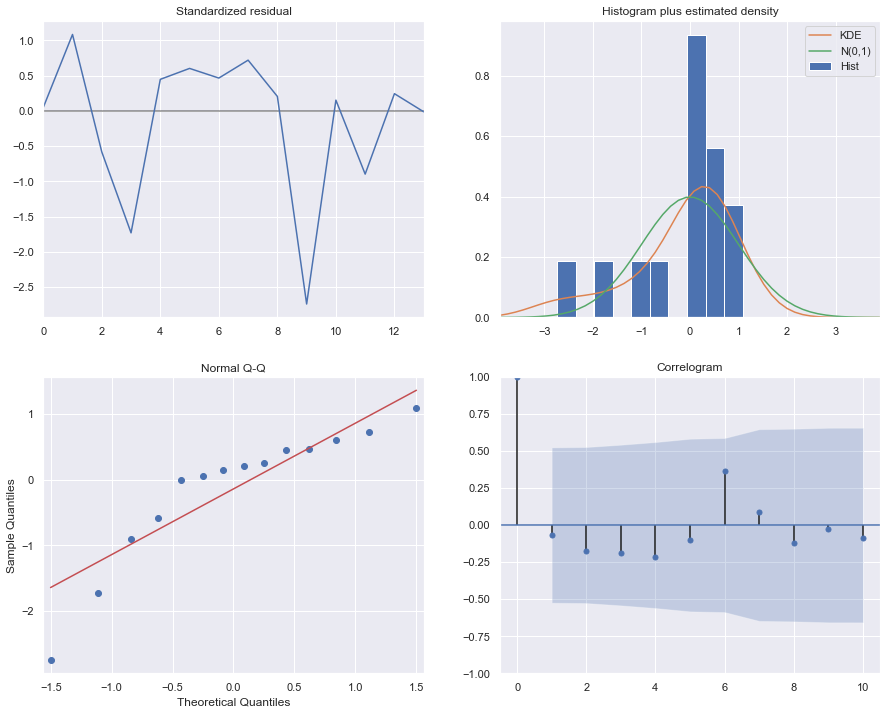

In [16]:
#let's print
results_2[mse_df_2.loc[:,'item'].iloc[0]].plot_diagnostics(figsize=(15, 12))
plt.show()

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

In [17]:
print(results_2[mse_df_2.loc[:,'item'].iloc[0]].summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2155      0.546     -0.395      0.693      -1.285       0.854
ma.L1         -0.9998      0.388     -2.578      0.010      -1.760      -0.240
ar.S.L12      -1.1618      0.101    -11.527      0.000      -1.359      -0.964
sigma2      4.361e+06   9.01e-08   4.84e+13      0.000    4.36e+06    4.36e+06


We can pretty much trust sigma2, ar.S.L12 & ma.L1

### Ok, let's now solve classification task

We will load file another dataset from another stage, where to each item is assigned corresponding type and category

In [14]:
df_type_category = pd.read_csv("topo_out_category_type_stage_2.csv")
df_type_category.head()

,item_code,parent_item_code,Category_code,Type,future_flag,1_item_quantity,2_item_quantity,3_item_quantity,4_item_quantity,5_item_quantity,...,36_parent_item_quantity,37_parent_item_quantity,38_parent_item_quantity,39_parent_item_quantity,40_parent_item_quantity,41_parent_item_quantity,42_parent_item_quantity,43_parent_item_quantity,44_parent_item_quantity,45_parent_item_quantity
0,9,163,5.0,AI/Stable,0,17,1,4,48,30,...,253,76,341,312,447,675,227,460,489,63
1,9,163,5.0,AI/Stable,1,0,1,4,4,26,...,37,65,155,96,118,357,140,309,131,56
2,9,163,5.0,AI/Stable,2,0,0,0,0,0,...,0,3,0,44,20,0,0,100,0,2
3,9,163,5.0,AI/Stable,3,0,0,0,0,0,...,0,3,0,4,20,0,0,0,0,2
4,15,11,7.0,Unstable,0,2580,1692,1043,2135,2505,...,1928,133,414,2010,383,792,458,324,309,321


In [15]:
#firstly let's make dataset a bit smaller for simplicity
X_df_type_category = df_type_category.loc[:,'item_code':'45_item_quantity']
X_df_type_category = X_df_type_category.drop(columns = 'parent_item_code')
X_df_type_category = X_df_type_category.groupby(['item_code','Category_code','Type']).sum()
X_df_type_category = X_df_type_category.drop(columns = 'future_flag')
X_df_type_category.head()

,,,1_item_quantity,2_item_quantity,3_item_quantity,4_item_quantity,5_item_quantity,6_item_quantity,7_item_quantity,8_item_quantity,9_item_quantity,10_item_quantity,...,36_item_quantity,37_item_quantity,38_item_quantity,39_item_quantity,40_item_quantity,41_item_quantity,42_item_quantity,43_item_quantity,44_item_quantity,45_item_quantity
item_code,Category_code,Type,,,,,,,,,,,,,,,,,,,,,
9,5.0,AI/Stable,17,2,8,52,56,120,43,85,50,147,...,322,159,596,466,605,1038,493,1282,634,129
15,7.0,Unstable,3886,2980,1636,3037,4427,3402,1690,1253,1463,3433,...,2798,254,755,4315,771,1658,672,589,656,608
16,7.0,Unstable,1550,1468,2807,3322,2574,3610,3160,3188,3010,3246,...,999,1213,1110,1083,598,1047,922,916,860,425
17,7.0,Unstable,1153,1046,658,1755,5409,3022,2150,5183,1982,3283,...,278,988,585,170,74,93,1738,320,1064,149
18,7.0,Unstable,9927,11144,16003,11409,14467,18337,8291,9595,12974,14926,...,17720,12075,8317,11923,13554,14944,24783,14829,8845,9581


There 82 different categories and 4 different types

In [16]:
#split into X & y 

X_df_type_category = X_df_type_category.reset_index()
X_df_type_category.replace({"Type": {"AI/Stable":0 , "Unstable": 1,"PTO":2,"P/Bottom":3},}, inplace=True)
y_category = X_df_type_category.loc[:,'Category_code']
y_type = X_df_type_category.loc[:,'Type']
X_category_type = X_df_type_category.loc[:,'1_item_quantity':'45_item_quantity']


In [17]:
X_df_type_train, X_df_type_test, y_type_train, y_type_test = train_test_split(X_df_type_category, y_type, test_size=0.15, random_state=0)
X_df_category_train, X_df_category_test, y_category_train, y_category_test = train_test_split(X_df_type_category, y_category, test_size=0.15, random_state=0)

clf_type = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
clf_category = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")


clf_type.fit(X_df_type_train.values,y_type_train)
clf_category.fit(X_df_category_train.values,y_category_train)


In [33]:
ac_type_dtw = accuracy_score(clf_type.predict(X_df_type_test.values), y_type_test)
ac_category_dtw = accuracy_score(clf_category.predict(X_df_category_test.values), y_category_test)

In [34]:
print("Nearest neighbor classification using DTW")
print("Correct classification rate for types:", ac_type_dtw)
print("Correct classification rate for categorie:",ac_category_dtw)


2. Nearest neighbor classification using DTW
Correct classification rate for types: 0.5403225806451613
Correct classification rate for categorie: 0.25


In [37]:
# Nearest neighbor classification with a different metric (Euclidean distance)
clf_type = KNeighborsTimeSeriesClassifier(n_neighbors=5, metric="euclidean")
clf_category = KNeighborsTimeSeriesClassifier(n_neighbors=5, metric="euclidean")
clf_type.fit(X_df_type_train.values,y_type_train)
clf_category.fit(X_df_category_train.values,y_category_train)
ac_type_euclidean = accuracy_score(clf_type.predict(X_df_type_test.values), y_type_test)
ac_category_euclidean = accuracy_score(clf_category.predict(X_df_category_test.values), y_category_test)
print("Nearest neighbor classification using L2")
print("Correct classification rate for types:", ac_type_euclidean)
print("Correct classification rate for categorie:",ac_category_euclidean)


2. Nearest neighbor classification using L2
Correct classification rate for types: 0.41935483870967744
Correct classification rate for categorie: 0.21774193548387097


In [55]:
# Nearest neighbor classification  based on SAX representation
from  tslearn.piecewise import SymbolicAggregateApproximation
from sklearn.pipeline import Pipeline
sax_trans = SymbolicAggregateApproximation(n_segments=10, alphabet_size_avg=5)
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
pipeline_model = Pipeline(steps=[('sax', sax_trans), ('knn', knn_clf)])
pipeline_model.fit(X_df_type_train.values, y_type_train)
predicted_labels = pipeline_model.predict(X_df_type_test.values)
print("earest neighbor classification using SAX+MINDIST")
ac_type_SAX_MINDIST = accuracy_score(predicted_labels, y_type_test)
print("Correct classification rate for types:", ac_type_SAX_MINDIST)


4. Nearest neighbor classification using SAX+MINDIST
Correct classification rate for types: 0.3790322580645161


In [54]:
pipeline_model.fit(X_df_category_train.values, y_category_train)
predicted_labels = pipeline_model.predict(X_df_category_test.values)
print("Nearest neighbor classification using SAX+MINDIST")
ac_category_SAX_MINDIST =  accuracy_score(predicted_labels, y_category_test)
print("Correct classification rate for category:",ac_category_SAX_MINDIST)


4. Nearest neighbor classification using SAX+MINDIST
Correct classification rate for category: 0.1693548387096774


It seems that DTW has the best accuracy for this dataset. 

Let's also try to cluster this time series into 4 clusters(because of 4 types)

Init 1
1421.089 --> 1259.268 --> 1235.872 --> 1244.450 --> 1245.160 --> 1248.769 --> 1252.529 --> 1257.588 --> 1260.129 --> 1261.416 --> 1258.723 --> 1260.757 --> 1260.757 --> 
Init 2
1421.001 --> 1304.049 --> 1230.544 --> 1223.072 --> 1236.417 --> 1249.041 --> 1256.013 --> 1257.843 --> 1258.483 --> 1258.483 --> 
Init 3
1409.331 --> 1253.000 --> 1246.730 --> 1250.122 --> 1257.292 --> 1261.250 --> 1261.690 --> 1261.690 --> 
Init 4
1412.818 --> 1263.158 --> 1261.721 --> 1260.007 --> 1257.869 --> 1254.303 --> 1255.683 --> 1255.629 --> 1254.858 --> 1254.083 --> 1254.083 --> 
Init 5
1410.153 --> 1280.814 --> 1221.891 --> 1206.418 --> 1215.431 --> 1229.607 --> 1235.250 --> 1238.764 --> 1240.571 --> 1241.829 --> 1245.126 --> 1247.785 --> 1250.497 --> 1251.917 --> 1252.636 --> 1252.636 --> 
Init 6
1417.629 --> 1291.457 --> 1225.372 --> 1215.621 --> 1233.160 --> 1240.028 --> 1244.558 --> 1247.953 --> 1245.372 --> 1244.931 --> 1245.628 --> 1246.992 --> 1246.992 --> 
Init 7
1391.680 --> 1271.016 

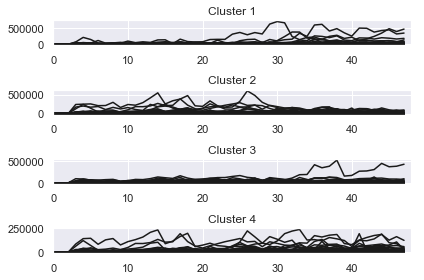

In [78]:
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak, cdist_gak
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

sz = X_df_type_category.values.shape[1]

gak_km = GlobalAlignmentKernelKMeans(n_clusters=4, sigma=sigma_gak(X_df_type_category.values), n_init=20, verbose=True, random_state=seed)
y_pred_type = gak_km.fit_predict(X_df_type_category.values)

plt.figure()
for yi in range(4):
    plt.subplot(4, 1, 1 + yi)
    for xx in X_df_type_category.values[y_pred_type == yi]:
        plt.plot(xx.ravel(), "k-")
    plt.xlim(0, sz)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

Let's compare with existing types:

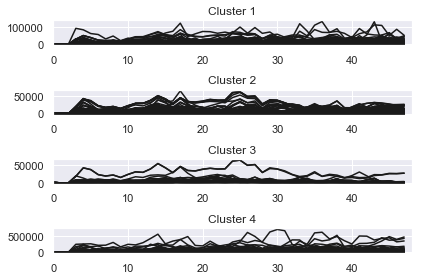

In [79]:
X_df_type_train.loc[X_df_type_train['Type'].isin([1])]
plt.figure()
for yi in range(4):
    plt.subplot(4, 1, 1 + yi)
    for xx in X_df_type_category.loc[X_df_type_category['Type'].isin([yi])].values:
        plt.plot(xx.ravel(), "k-")
    plt.xlim(0, sz)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [85]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
print('Accuracy score:', adjusted_rand_score(y_pred_type, X_df_type_category.loc[:,'Type']))
print(confusion_matrix(y_pred_type, X_df_type_category.loc[:,'Type']))

Accuracy score: 0.026113149181068135
[[ 48  22   7  51]
 [ 32  29   6  53]
 [201  79   6 171]
 [ 43  36   3  39]]


It seems algorithm clustered data quite differently

Let's also see if we can improve our prediction if we include future flag in analysis:

In [34]:
df_type_category = pd.read_csv("topo_out_category_type_stage_2.csv")
df_type_category.head()
#firstly let's make dataset a bit smaller for simplicity
X_df_type_category = df_type_category.loc[:,'item_code':'45_item_quantity']
X_df_type_category = X_df_type_category.drop(columns = 'parent_item_code')
X_df_type_category.replace({"Type": {"AI/Stable":0 , "Unstable": 1,"PTO":2,"P/Bottom":3},}, inplace=True)
y_category = X_df_type_category.loc[:,'Category_code']
y_type = X_df_type_category.loc[:,'Type']
X_category_type = X_df_type_category.loc[:,'1_item_quantity':'45_item_quantity']

We could have applied DTW, which showed the best results previously, but it calcluated too long. Let's try euclidean

In [38]:
X_df_type_train, X_df_type_test, y_type_train, y_type_test = train_test_split(X_df_type_category, y_type, test_size=0.15, random_state=0)
X_df_category_train, X_df_category_test, y_category_train, y_category_test = train_test_split(X_df_type_category, y_category, test_size=0.15, random_state=0)
clf_type = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
clf_category = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="euclidean")
clf_type.fit(X_df_type_train.values,y_type_train)
clf_category.fit(X_df_category_train.values,y_category_train)
ac_type_dtw = accuracy_score(clf_type.predict(X_df_type_test.values), y_type_test)
#ac_category_dtw = accuracy_score(clf_category.predict(X_df_category_test.values), y_category_test)
print("Nearest neighbor classification using Euclidean with future flag")
print("Correct classification rate for types:", ac_type_dtw)
#print("Correct classification rate for categorie:",ac_category_dtw)

Nearest neighbor classification using Euclidean with future flag
Correct classification rate for types: 0.7688679245283019


# Results

**Findings**
1. Have found that AMIRA with parameters (1, 1, 1)x(1, 1, 0, 12) works best with this dataset. Moreover we have found set of items for which the prediction resembles the actual data, therefore potentially for this items forecast with AMIRA can be used. Also the residuals are normally distributed for this prediction
2. Have solved classification problem with acc 0.54 & 0.25 accuracy for correspondingly 4 types & 84 categories. Adding 
Have found that Dynamic time warping (DWP) works better than other algorithms for this dataset. This classification can aid the forecast by improving accuracy, for example if we have new set of items, but don't  know their corresponding type & category. 
3. If we classify by types using future flag, we will improve classification rate for items up to **77%**

**Remarks**
1. This is really applied problem, which shows that indeed Data Science can be used in industry. Moreover we've just scraped the survace of what was possible and  a lot of insight could be found given more data (which could be given in industry) and time.
2. It is really not so obvious what approach/method to use while working with data. There are plenty of them and each of them requires time to accordingly preproccess. So the best strategy was to use either known ones or just pick random one and hope that they will work.

**Conclusion**
1. Really need to study "cookbook" of possible methods, to know, which algorithm should be used for particular type and format of data. This would be really aidful in future research.